In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model, sklearn.calibration

import loader
from models import DummyEstimator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.5  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

max_workers = 32

data_dir = "data/adult"

In [2]:
## Load UCI Adult dataset
dataset_name = "Adult"

(inputs_df, labels, label_names, groups,
 group_names) = loader.load_adult(data_dir)
inputs_u_df = loader.load_adult(data_dir, remove_sensitive_attr=True)[0]
      
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32)
inputs_u = np.array(inputs_u_df.values, dtype=np.float32)

Group,Female,Male
Target,,
<=50K,14423,22732
>50K,1769,9918


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

In [4]:
# Calibrator definition

calibrator_ay_factory = partial(sklearn.calibration.CalibratedClassifierCV,
                             estimator=DummyEstimator(n_classes * n_groups),
                             cv='prefit',
                             method='sigmoid')

## Logistic regression

In [5]:
model_name = 'log. reg.'

# Train attribute aware p(Y | X, A) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.06661201433774125


Binned ECE of attribute blind predictor: 0.2605882867743759


In [6]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}

  0%|                                                    | 0/70 [00:00<?, ?it/s]

 46%|███████████████████▋                       | 32/70 [00:00<00:01, 36.14it/s]

 91%|███████████████████████████████████████▎   | 64/70 [00:04<00:00, 12.32it/s]

100%|███████████████████████████████████████████| 70/70 [00:04<00:00, 14.95it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 2639.90it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 2997.28it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 3234.95it/s]

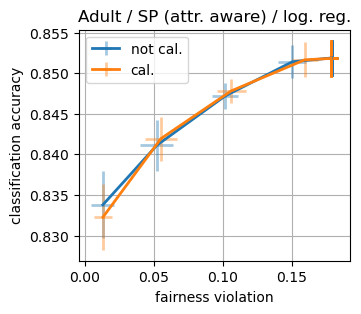

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.851870  0.002166  0.178678  0.004754
0.600  0.851870  0.002166  0.178678  0.004754
0.550  0.851870  0.002166  0.178678  0.004754
0.500  0.851870  0.002166  0.178678  0.004754
0.450  0.851870  0.002166  0.178678  0.004754
0.400  0.851870  0.002166  0.178678  0.004754
0.350  0.851870  0.002166  0.178678  0.004754
0.300  0.851870  0.002166  0.178678  0.004754
0.250  0.851870  0.002166  0.178678  0.004754
0.200  0.851870  0.002166  0.178678  0.004754
0.150  0.851406  0.002001  0.150408  0.010115
0.100  0.847188  0.001604  0.101662  0.009478
0.050  0.841127  0.003131  0.052319  0.011967
0.001  0.833784  0.004118  0.013178  0.008252

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.851815  0.002239  0.178304  0.004729
0.600  0.851815  0.002239  0.178304  0.004729
0.550  0.851815  0.002239  0.178304  0.004729
0.500  0.851815  0.002239  0.178304  0.004729
0.450  0.851815  0.002239  0.178304  0.004729
0.400  0.851815  0.002239  0.178304  0.004729
0.350  0.851815  0.002239  0.178304  0.004729
0.300  0.851815  0.002239  0.178304  0.004729
0.250  0.851815  0.002239  0.178304  0.004729
0.200  0.851815  0.002239  0.178304  0.004729
0.150  0.851638  0.002153  0.159221  0.009428
0.100  0.847802  0.001518  0.106007  0.010473
0.050  0.841933  0.002697  0.055175  0.011739
0.001  0.832255  0.004065  0.013199  0.006719

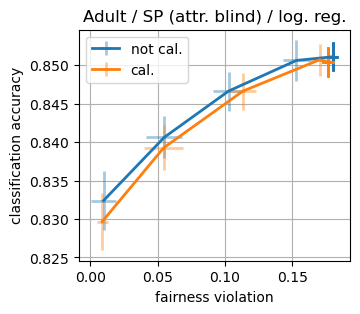

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.851078  0.001892  0.180177  0.003911
0.600  0.851078  0.001892  0.180177  0.003911
0.550  0.851078  0.001892  0.180177  0.003911
0.500  0.851078  0.001892  0.180177  0.003911
0.450  0.851078  0.001892  0.180177  0.003911
0.400  0.851078  0.001892  0.180177  0.003911
0.350  0.851078  0.001892  0.180177  0.003911
0.300  0.851078  0.001892  0.180177  0.003911
0.250  0.851078  0.001892  0.180177  0.003911
0.200  0.851078  0.001892  0.180177  0.003911
0.150  0.850601  0.002627  0.153165  0.010151
0.100  0.846628  0.002533  0.102839  0.011490
0.050  0.840609  0.002743  0.054973  0.013380
0.001  0.832391  0.003813  0.009886  0.008951

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.850341  0.001949  0.176663  0.004217
0.600  0.850355  0.001938  0.176684  0.004239
0.550  0.850355  0.001938  0.176684  0.004239
0.500  0.850355  0.001938  0.176684  0.004239
0.450  0.850355  0.001938  0.176684  0.004239
0.400  0.850355  0.001938  0.176684  0.004239
0.350  0.850355  0.001938  0.176684  0.004239
0.300  0.850355  0.001938  0.176684  0.004239
0.250  0.850355  0.001938  0.176684  0.004239
0.200  0.850355  0.001938  0.176684  0.004239
0.150  0.850696  0.002101  0.170439  0.008081
0.100  0.846615  0.002398  0.113400  0.010032
0.050  0.839257  0.002915  0.054617  0.014575
0.001  0.829661  0.003718  0.008885  0.003982

In [7]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15,
                0.1, 0.05, 0.001]
alphas_blind = [np.inf, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15,
                0.1, 0.05, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 16420.88it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1628.67it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 10830.30it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 2263.03it/s]

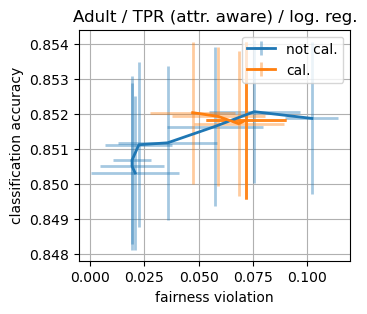

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.851870  0.002166   0.101989  0.012120
0.100  0.852061  0.002036   0.075542  0.020887
0.080  0.851638  0.002262   0.057342  0.022201
0.060  0.851174  0.002200   0.035635  0.022835
0.040  0.851119  0.002356   0.022422  0.015420
0.020  0.850683  0.002396   0.019280  0.008860
0.010  0.850505  0.002384   0.019300  0.014899
0.001  0.850314  0.002201   0.020706  0.020102

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.851815  0.002239   0.071634  0.018380
0.100  0.851815  0.002239   0.071634  0.018380
0.080  0.851815  0.002239   0.071634  0.018380
0.060  0.851815  0.002239   0.071634  0.018380
0.040  0.851815  0.002239   0.071634  0.018380
0.020  0.851720  0.002063   0.068322  0.020688
0.010  0.851925  0.001994   0.059030  0.021377
0.001  0.852034  0.002026   0.047168  0.019463

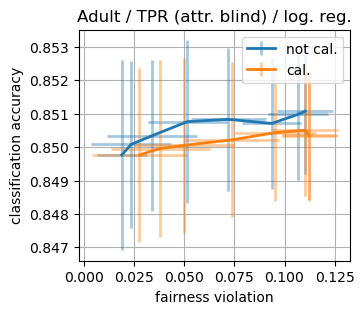

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.851078  0.001892   0.110289  0.014067
0.100  0.850983  0.001964   0.106829  0.014927
0.080  0.850710  0.001971   0.093617  0.014575
0.060  0.850833  0.002150   0.072079  0.018759
0.040  0.850764  0.002437   0.051685  0.019562
0.020  0.850341  0.002255   0.034034  0.022282
0.010  0.850082  0.002497   0.023621  0.019728
0.001  0.849768  0.002854   0.019004  0.012495

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.850341  0.001949   0.112315  0.013632
0.100  0.850355  0.001938   0.112382  0.013680
0.080  0.850505  0.001960   0.110319  0.016337
0.060  0.850437  0.002035   0.095501  0.020332
0.040  0.850218  0.002323   0.073858  0.023608
0.020  0.850055  0.002629   0.050131  0.025102
0.010  0.849959  0.002651   0.038148  0.024604
0.001  0.849768  0.002609   0.027786  0.023543

In [8]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'TPR'
alphas_aware = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7544.05it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1930.41it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 26617.83it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 2066.87it/s]

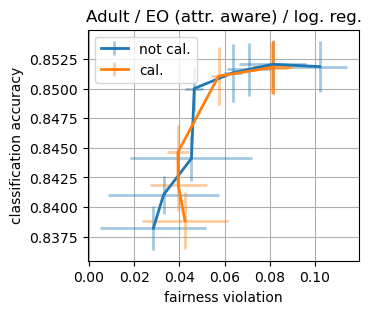

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.851870  0.002166  0.101989  0.012120
0.100  0.852061  0.002036  0.081227  0.014849
0.080  0.851638  0.002262  0.070771  0.009929
0.060  0.851351  0.002462  0.063690  0.004098
0.040  0.850014  0.001862  0.046551  0.004003
0.020  0.844103  0.001946  0.045315  0.026997
0.010  0.841032  0.001604  0.032989  0.024644
0.001  0.838206  0.001861  0.028472  0.023453

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.851815  0.002239  0.081206  0.008606
0.100  0.851815  0.002239  0.081206  0.008606
0.080  0.851815  0.002239  0.081206  0.008606
0.060  0.851775  0.002179  0.080384  0.007698
0.040  0.851065  0.002451  0.057332  0.003490
0.020  0.844636  0.002261  0.039354  0.005067
0.010  0.841878  0.002177  0.039448  0.012621
0.001  0.838848  0.002431  0.042430  0.018921

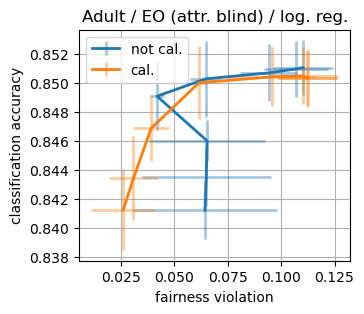

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.851078  0.001892  0.110289  0.014067
0.100  0.850983  0.001964  0.106829  0.014927
0.080  0.850710  0.001971  0.094213  0.013382
0.060  0.850300  0.002626  0.064717  0.007324
0.040  0.849099  0.002335  0.041870  0.003283
0.020  0.846014  0.001405  0.065307  0.027007
0.010  0.843475  0.001958  0.064939  0.030213
0.001  0.841209  0.002000  0.064326  0.033767

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.850341  0.001949  0.112315  0.013632
0.100  0.850355  0.001938  0.112382  0.013680
0.080  0.850505  0.001960  0.110319  0.016337
0.060  0.850437  0.002035  0.095501  0.020332
0.040  0.850027  0.002531  0.061515  0.003833
0.020  0.846874  0.002247  0.039152  0.008308
0.010  0.843421  0.002905  0.030858  0.011363
0.001  0.841237  0.002797  0.026115  0.014911

In [9]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

## Gradient boosting decision tree

In [10]:
model_name = 'GBDT'

# Train attribute aware p(Y | X, A) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain, verbosity=0)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain,
                                         verbosity=0)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.05617998473966751


Binned ECE of attribute blind predictor: 0.3326203835478164


In [11]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}

  0%|                                                    | 0/65 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 3466.98it/s]

  0%|                                                    | 0/65 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 65/65 [00:00<00:00, 660.40it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 2898.62it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 3057.87it/s]

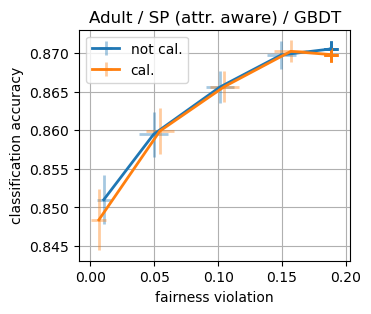

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.870530  0.001009  0.188283  0.005546
0.550  0.870530  0.001009  0.188324  0.005563
0.500  0.870530  0.001009  0.188324  0.005563
0.450  0.870530  0.001009  0.188324  0.005563
0.400  0.870530  0.001009  0.188324  0.005563
0.350  0.870530  0.001009  0.188324  0.005563
0.300  0.870530  0.001009  0.188324  0.005563
0.250  0.870530  0.001009  0.188324  0.005563
0.200  0.870530  0.001009  0.188324  0.005563
0.150  0.869752  0.001757  0.149422  0.011337
0.100  0.865588  0.002037  0.101363  0.010934
0.050  0.859459  0.002866  0.049403  0.011030
0.001  0.850996  0.003138  0.010386  0.005523

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.869793  0.000894  0.188589  0.005356
0.550  0.869793  0.000894  0.188589  0.005356
0.500  0.869793  0.000894  0.188589  0.005356
0.450  0.869793  0.000894  0.188589  0.005356
0.400  0.869793  0.000894  0.188589  0.005356
0.350  0.869793  0.000894  0.188589  0.005356
0.300  0.869793  0.000894  0.188589  0.005356
0.250  0.869793  0.000894  0.188589  0.005356
0.200  0.869793  0.000894  0.188589  0.005356
0.150  0.870216  0.001443  0.156914  0.012851
0.100  0.865643  0.002025  0.104818  0.011359
0.050  0.859896  0.003040  0.054351  0.011112
0.001  0.848389  0.003937  0.006565  0.005785

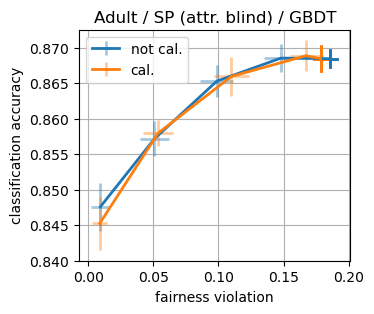

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.868482  0.001342  0.186011  0.005891
0.600  0.868482  0.001342  0.186011  0.005891
0.550  0.868482  0.001342  0.186011  0.005891
0.500  0.868482  0.001342  0.186011  0.005891
0.450  0.868482  0.001342  0.186011  0.005891
0.400  0.868482  0.001342  0.186011  0.005891
0.350  0.868482  0.001342  0.186011  0.005891
0.300  0.868482  0.001342  0.186011  0.005891
0.250  0.868482  0.001342  0.186011  0.005891
0.200  0.868482  0.001342  0.186011  0.005891
0.150  0.868564  0.002012  0.148023  0.013143
0.100  0.865315  0.002248  0.098820  0.012691
0.050  0.857194  0.002427  0.050934  0.011504
0.001  0.847584  0.003361  0.009377  0.006821

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.868482  0.001916  0.178460  0.005874
0.600  0.868482  0.001916  0.178460  0.005874
0.550  0.868482  0.001916  0.178460  0.005874
0.500  0.868482  0.001916  0.178460  0.005874
0.450  0.868482  0.001916  0.178460  0.005874
0.400  0.868482  0.001916  0.178460  0.005874
0.350  0.868482  0.001916  0.178460  0.005874
0.300  0.868482  0.001916  0.178460  0.005874
0.250  0.868482  0.001916  0.178460  0.005874
0.200  0.868482  0.001916  0.178460  0.005874
0.150  0.868905  0.002182  0.167370  0.012622
0.100  0.865984  0.002718  0.110048  0.013464
0.050  0.857972  0.001807  0.053677  0.011779
0.001  0.845236  0.003780  0.008882  0.005676

In [12]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                0.05, 0.001]
alphas_blind = [np.inf, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15,
                0.1, 0.05, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 20812.82it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1747.08it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 10249.38it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 6195.66it/s]

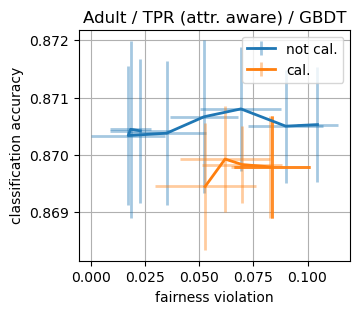

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.870530  0.001009   0.104615  0.009519
0.100  0.870502  0.000984   0.089898  0.017433
0.080  0.870803  0.001085   0.069172  0.018765
0.060  0.870666  0.001333   0.052135  0.015720
0.040  0.870379  0.001254   0.034801  0.018176
0.020  0.870339  0.001203   0.017048  0.017009
0.010  0.870448  0.001542   0.018153  0.009441
0.001  0.870420  0.001251   0.022665  0.013958

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.869793  0.000894   0.083521  0.017541
0.100  0.869793  0.000894   0.083521  0.017541
0.080  0.869793  0.000894   0.083521  0.017541
0.060  0.869793  0.000894   0.083521  0.017541
0.040  0.869793  0.000894   0.082808  0.018212
0.020  0.869833  0.000664   0.069748  0.018482
0.010  0.869929  0.000929   0.061849  0.020640
0.001  0.869451  0.001110   0.052635  0.023413

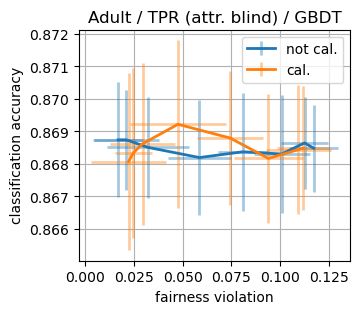

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.868482  0.001342   0.117159  0.012465
0.100  0.868646  0.001411   0.112457  0.012107
0.080  0.868305  0.001823   0.100711  0.014380
0.060  0.868373  0.001820   0.080870  0.012869
0.040  0.868195  0.001777   0.058621  0.015974
0.020  0.868509  0.001546   0.032162  0.020941
0.010  0.868741  0.001547   0.021122  0.016821
0.001  0.868741  0.001771   0.016954  0.012524

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.868482  0.001916   0.111686  0.013486
0.100  0.868441  0.001974   0.109338  0.016453
0.080  0.868168  0.001978   0.093953  0.017873
0.060  0.868796  0.002055   0.074319  0.016931
0.040  0.869219  0.002586   0.047627  0.024809
0.020  0.868619  0.002489   0.029465  0.016675
0.010  0.868332  0.002612   0.024628  0.009501
0.001  0.868073  0.002729   0.022308  0.019010

In [13]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'TPR'
alphas_aware = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 6010.97it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1966.02it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 19004.55it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 948.57it/s]

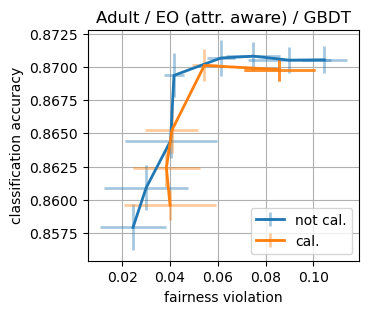

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.870530  0.001009  0.104615  0.009519
0.100  0.870502  0.000984  0.089933  0.017383
0.080  0.870803  0.001085  0.074900  0.011276
0.060  0.870666  0.001333  0.061355  0.005911
0.040  0.869356  0.001648  0.041610  0.004195
0.020  0.864442  0.001304  0.040215  0.019261
0.010  0.860920  0.001690  0.029978  0.017481
0.001  0.857944  0.001722  0.024471  0.013704

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.869793  0.000894  0.085841  0.014756
0.100  0.869793  0.000894  0.085841  0.014756
0.080  0.869793  0.000894  0.085841  0.014756
0.060  0.869793  0.000894  0.085841  0.014756
0.040  0.870106  0.001197  0.054366  0.005168
0.020  0.865233  0.001734  0.040760  0.011077
0.010  0.862422  0.001465  0.038450  0.014083
0.001  0.859610  0.001111  0.039973  0.019144

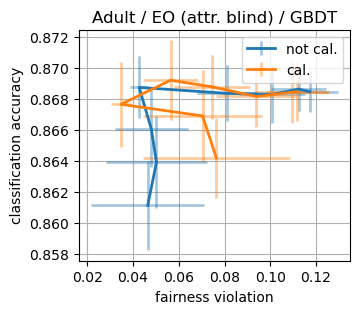

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.868482  0.001342  0.117159  0.012465
0.100  0.868646  0.001411  0.112457  0.012107
0.080  0.868305  0.001823  0.100711  0.014380
0.060  0.868373  0.001820  0.080870  0.012869
0.040  0.868755  0.002008  0.042682  0.003948
0.020  0.866093  0.002505  0.047951  0.015975
0.010  0.863923  0.002955  0.050256  0.022221
0.001  0.861125  0.002894  0.046424  0.024575

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.868482  0.001916  0.111686  0.013486
0.100  0.868441  0.001974  0.109338  0.016453
0.080  0.868168  0.001978  0.093953  0.017873
0.060  0.868796  0.002055  0.074437  0.016711
0.040  0.869219  0.002586  0.056451  0.012076
0.020  0.867663  0.002761  0.034722  0.004552
0.010  0.866912  0.002956  0.070396  0.025832
0.001  0.864196  0.002583  0.076428  0.032005

In [14]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)